In [69]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [70]:
df = pd.read_csv('events_log_.csv', parse_dates=['timestamp'], index_col='timestamp')

In [71]:
df.head()

,Unnamed: 0,Unnamed: 0.1,uuid,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,,,,
2016-03-01 10:38:42,0,0,00000736167c507e8ec225bd9e71f9e5,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
2016-03-07 00:52:26,1,1,00000c69fe345268935463abbfa5d5b3,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2016-03-02 14:53:05,2,2,00003bfdab715ee59077a3670331b787,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
2016-03-02 22:27:01,3,3,0000465cd7c35ad2bdeafec953e08c1a,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
2016-03-02 09:50:23,4,4,000050cbb4ef5b42b16c4d2cf69e6358,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN


In [118]:
def CRT(df):
    clickthroughrate = float(len(d['action'][d['action'] == 'visitPage'])) / float(len(d['action'][d['action'] == 'searchResultPage']))
    return clickthroughrate

def ZeroResults(df):
    zero_results = (float(len(d['n_results'][d['n_results'] == 0])) / float(len(d['action'][d['action'] == 'searchResultPage'])))
    return zero_results

def bars(list_means, list_SEM, title, ylabel):
    bar_width = 0.35
    
    index = np.arange(3)
    rects = ax.bar(range(len(list_means)), list_means, bar_width, color='k', alpha=0.5, yerr=list_SEM, error_kw=dict(ecolor='black', lw=2, capsize=5, capthick=2))

    plt.title(title,size=15)
    plt.xticks(index + bar_width / 2,('Overall', 'Group A','Group B'),size=13)
    plt.ylabel(ylabel,size=13)
    plt.yticks(np.round(np.linspace(0,max(list_means)+0.05,6),1),size=13)
    plt.legend()
    
def pairs_bars(series_A, series_B, title, ylabel):
    
    index = np.arange(8)
    rects1 = plt.bar(index, series_A, bar_width,
                     alpha=0.5,
                     color='b',
                     label='A')
    rects2 = plt.bar(index + bar_width, series_B, bar_width,
                     alpha=0.5,
                     color='r',
                     label='B')

    plt.title(title, size=15)
    plt.ylim([0, 1])
    plt.ylabel(ylabel, size=13)
    plt.xlabel('Day', size=13)
    plt.xticks(index + bar_width / 2, ('1', '2', '3', '4', '5','6','7','8'))

    plt.tight_layout()
    plt.legend()

In [73]:
crt = []
crtA = []
crtB = []

for i, d in df.groupby(df.index.day):
    crt.append(CRT(d))

for i, d in df.groupby([df.index.day, df.group]):
    if d['group'][0] == 'a':
        crtA.append(CRT(d))
    else:
        crtB.append(CRT(d))

In [74]:
zr = []
zrA = []
zrB = []

for i, d in df.groupby(df.index.day):
    zr.append(ZeroResults(d))

for i, d in df.groupby([df.index.day, df.group]):
    if d['group'][0] == 'a':
        zrA.append(ZeroResults(d))
    else:
        zrB.append(ZeroResults(d))

In [112]:
mean_CRT = sum(crt)/len(crt)
mean_CRT_A = sum(crtA)/len(crtA)
mean_CRT_B = sum(crtB)/len(crtB)

error_overall = stats.sem(crt)
error_a = stats.sem(crtA)
error_b = stats.sem(crtB)

CRT_ = [mean_CRT, mean_CRT_A, mean_CRT_B]
error_crt = [error_overall, error_a, error_b]

In [95]:
mean_zr = sum(zr)/len(zr)
mean_zr_A = sum(zrA)/len(zrA)
mean_zr_B = sum(zrB)/len(zrB)

error_overall_zr = stats.sem(zr)
error_a_zr = stats.sem(zrA)
error_b_zr = stats.sem(zrB)

zr = [mean_zr, mean_zr_A, mean_zr_B]
error_zr = [error_overall_zr, error_a_zr, error_b_zr]

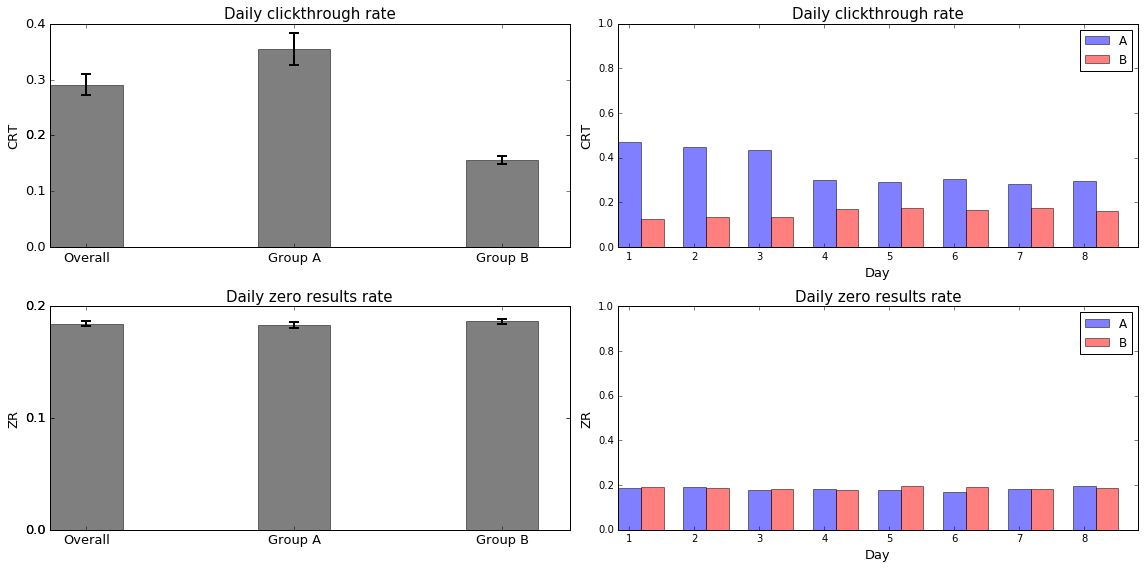

In [119]:
title = 'Daily clickthrough rate'
ylabel = 'CRT'
fig = plt.figure(figsize = [16,8])
ax = fig.add_subplot(221)
bars(CRT_, error_crt, title, ylabel)
ax2 = fig.add_subplot(222)
pairs_bars(crtA,crtB,title, ylabel)

title2 = 'Daily zero results rate'
ylabel2 = 'ZR'
ax = fig.add_subplot(223)
bars(zr, error_zr, title2, ylabel2)
ax2 = fig.add_subplot(224)
pairs_bars(zrA,zrB,title2,ylabel2)